In [1]:
# Environment setup
const DEPENDENCIES = ["GraphViz", "CairoMakie", "BenchmarkTools"];
import Pkg
Pkg.activate(temp=true)
Pkg.add(name="DataFlowTasks", rev="6bf3e19e84a92355cef0fba2fece75275a89b12a")
foreach(Pkg.add, DEPENDENCIES)

  Activating new project at `/tmp/jl_UbJyuW`
   Resolving package versions...
    Updating `/tmp/jl_UbJyuW/Project.toml`
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#6bf3e19`
    Updating `/tmp/jl_UbJyuW/Manifest.toml`
  [34da2185] + Compat v4.12.0
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#6bf3e19`
  [bac558e1] + OrderedCollections v1.6.3
  [6c6a2e73] + Scratch v1.2.1
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL v0.6.4
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [ca575930] + NetworkOptions v1.2.0
  [44cfe95a] + Pkg v1.10.0
  [de0858da] + Printf
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA v0.7.0
  [9e88b42a] + Serialization
  [6462fe0b] +

# Tiled Cholesky Factorization


We illustrate here the use of `DataFlowTasks` to parallelize a tiled Cholesky
factorization. The implementation shown here is delibarately made as simple
and self-contained as possible; yet, as we shall see when comparing to
*OpenBLAS*, it is already quite performant!

The Cholesky factorization algorithm takes a symmetric positive definite
matrix $A$ and finds a lower triangular matrix $L$ such that $A = LLᵀ$. The
tiled version of this algorithm decomposes the matrix $A$ into tiles (of even
sizes, in this simplified version). At each step of the algorithm, we do a
Cholesky factorization on the diagonal tile, use a triangular solve to update
all of the tiles at the right of the diagonal tile, and finally update all the
tiles of the submatrix with a schur complement.

If we have a matrix $A$ decomposed in $n \times n$ tiles, then the algorithm will
have $n$ steps. The $i$-th step (with $i \in [1:n]$) performs:

-  $1$ cholesky factorization of the $(i,i)$ tile,
-  $(i-1)$ triangular solves (one for each tile in the $i$-th row of the upper triangular matrix),
-  $i(i-1)/2$ matrix multiplications to update the submatrix.

These are the basic operations on tiles, which we are going to spawn in
separate tasks in the parallel implementation. Accounting for all iterations,
this makes a total of $\mathcal{O}(n^3)$ such tasks, decomposed as:

-  $\mathcal{O}(n)$ cholesky factorizations,
-  $\mathcal{O}(n^2)$ triangular solves,
-  $\mathcal{O}(n^3)$ matrix multiplications.

The following image illustrates the 2nd step of the algorithm:

![](https://github.com/maltezfaria/DataFlowTasks.jl/blob/1d101c3d738bcb35a93ed4c9db60a2ad66886fa5/docs/src/examples/cholesky/Cholesky_2ndStep.png?raw=true)

## Sequential implementation

A sequential tiled factorization algorithm can be implemented as:

In [2]:
using LinearAlgebra

tilerange(ti, ts) = (ti-1)*ts+1:ti*ts

function cholesky_tiled!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        cholesky!(T[i,i])

        # Left tiles update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            ldiv!(U', T[i,j])
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                mul!(T[j,k], T[i,j]', T[i,k], -1, 1)
            end
        end
    end

    # Construct the factorized object
    return Cholesky(A, 'U', zero(LinearAlgebra.BlasInt))
end

cholesky_tiled! (generic function with 1 method)

Let us build a small test case to check the correctness of the
factorization. Here we divide a matrix of size 4096×4096 in 8×8 tiles of size
512×512:

In [3]:
n  = 4096
ts = 512
A = rand(n, n)
A = (A + adjoint(A))/2
A = A + n*I;

and the results seem to be correct:

In [4]:
F = cholesky_tiled!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err
@assert err < eps(Float64)

err = 2.081337286499231e-17


## Parallel implementation

In order to parallelize the code with `DataFlowTasks.jl`, function calls
acting on tiles are wrapped within `@dspawn`, along with annotations
describing data access modes. We also give meaningful labels to the tasks,
which will help debug and profile the code.

In [5]:
using DataFlowTasks

function cholesky_dft!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        @dspawn cholesky!(@RW(T[i,i])) label="chol ($i,$i)"

        # Left tiles update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            @dspawn ldiv!(@R(U)', @RW(T[i,j])) label="ldiv ($i,$j)"
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                @dspawn schur_complement!(@RW(T[j,k]), @R(T[i,j])', @R(T[i,k])) label="schur ($j,$k)"
            end
        end
    end

    # Construct the factorized object
    r = @dspawn Cholesky(@R(A), 'U', zero(LinearAlgebra.BlasInt)) label="result"
    return fetch(r)
end

schur_complement!(C, A, B) = mul!(C, A, B, -1, 1)

schur_complement! (generic function with 1 method)

Again, let us check the correctness of the result:

In [6]:
F = cholesky_dft!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err
@assert err < eps(Float64)

err = 2.081337286499231e-17


## Debugging and Profiling

Let us now check what happens during a parallel run of our cholesky
factorization. Thanks to the test above, the code is now compiled. Let's re-run it and collect
meaningful profiling information:

In [7]:
# Clean profiling environment
GC.gc()

# Real workload to be analysed
Ac = copy(A)
log_info = DataFlowTasks.@log cholesky_dft!(Ac, ts)

LogInfo with 121 logged tasks


The number of tasks being $\mathcal{O}(n^3)$, we can see how quickly the DAG
complexity increases (even though the test case only has 8×8 tiles here):

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.10/Project.toml`
⌃ [13f3f980] CairoMakie v0.11.5
⌃ [e9467ef8] GLMakie v0.9.5
  [f526b714] GraphViz v0.2.0
⌅ [ee78f7c6] Makie v0.20.4
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


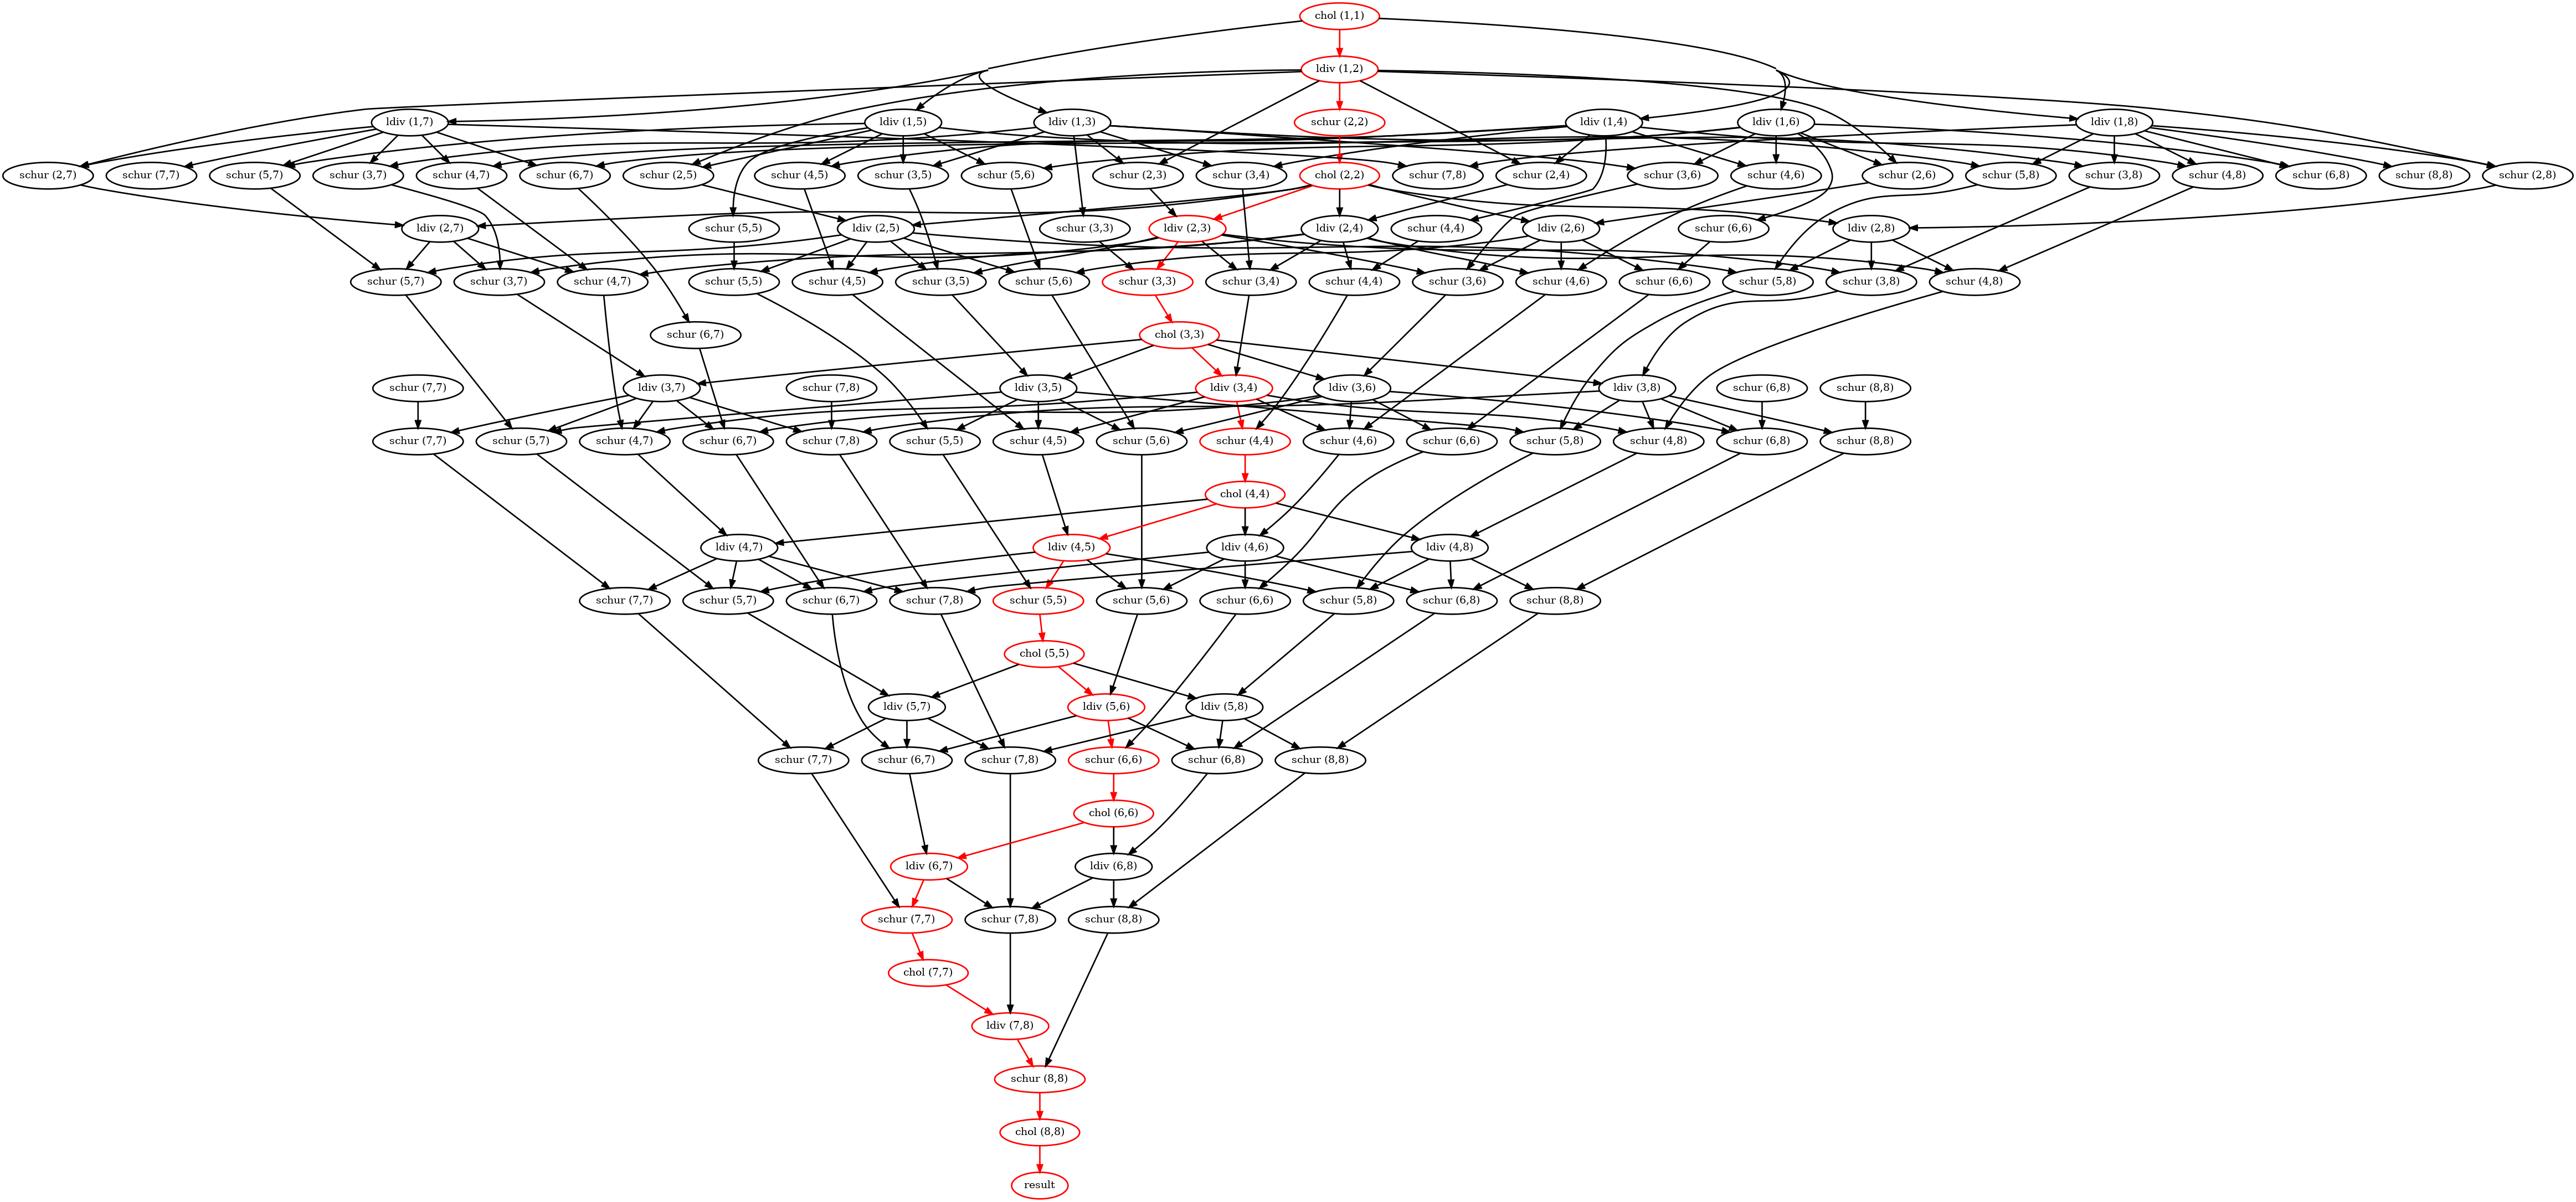

In [8]:
DataFlowTasks.stack_weakdeps_env!()
using GraphViz
dag = GraphViz.Graph(log_info)

The critical path, highlighted in red, includes all cholesky factorizations of
diagonal tiles, as well as the required tasks in between them.

We can also readily get more details about the performance limiting factors:

In [9]:
DataFlowTasks.describe(log_info; categories=["chol", "ldiv", "schur"])

• Elapsed time           : 0.260
  ├─ Critical Path       : 0.237
  ╰─ No-Wait             : 0.190

• Run time               : 2.082
  ├─ Computing           :   1.518
  │  ├─ chol             :     0.098
  │  ├─ ldiv             :     0.233
  │  ├─ schur            :     1.188
  │  ╰─ unlabeled        :     0.000
  ├─ Task Insertion      :   0.004
  ╰─ Other (idle)        :   0.559


and, at the price of loading `Makie`, display these in a more convenient
profile plot:

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/z2T2o/src/scenes.jl:220
[ Info: Computing    : 1.5182846239999999
[ Info: Inserting    : 0.004367966999999999
[ Info: Other        : 0.5591375582118828


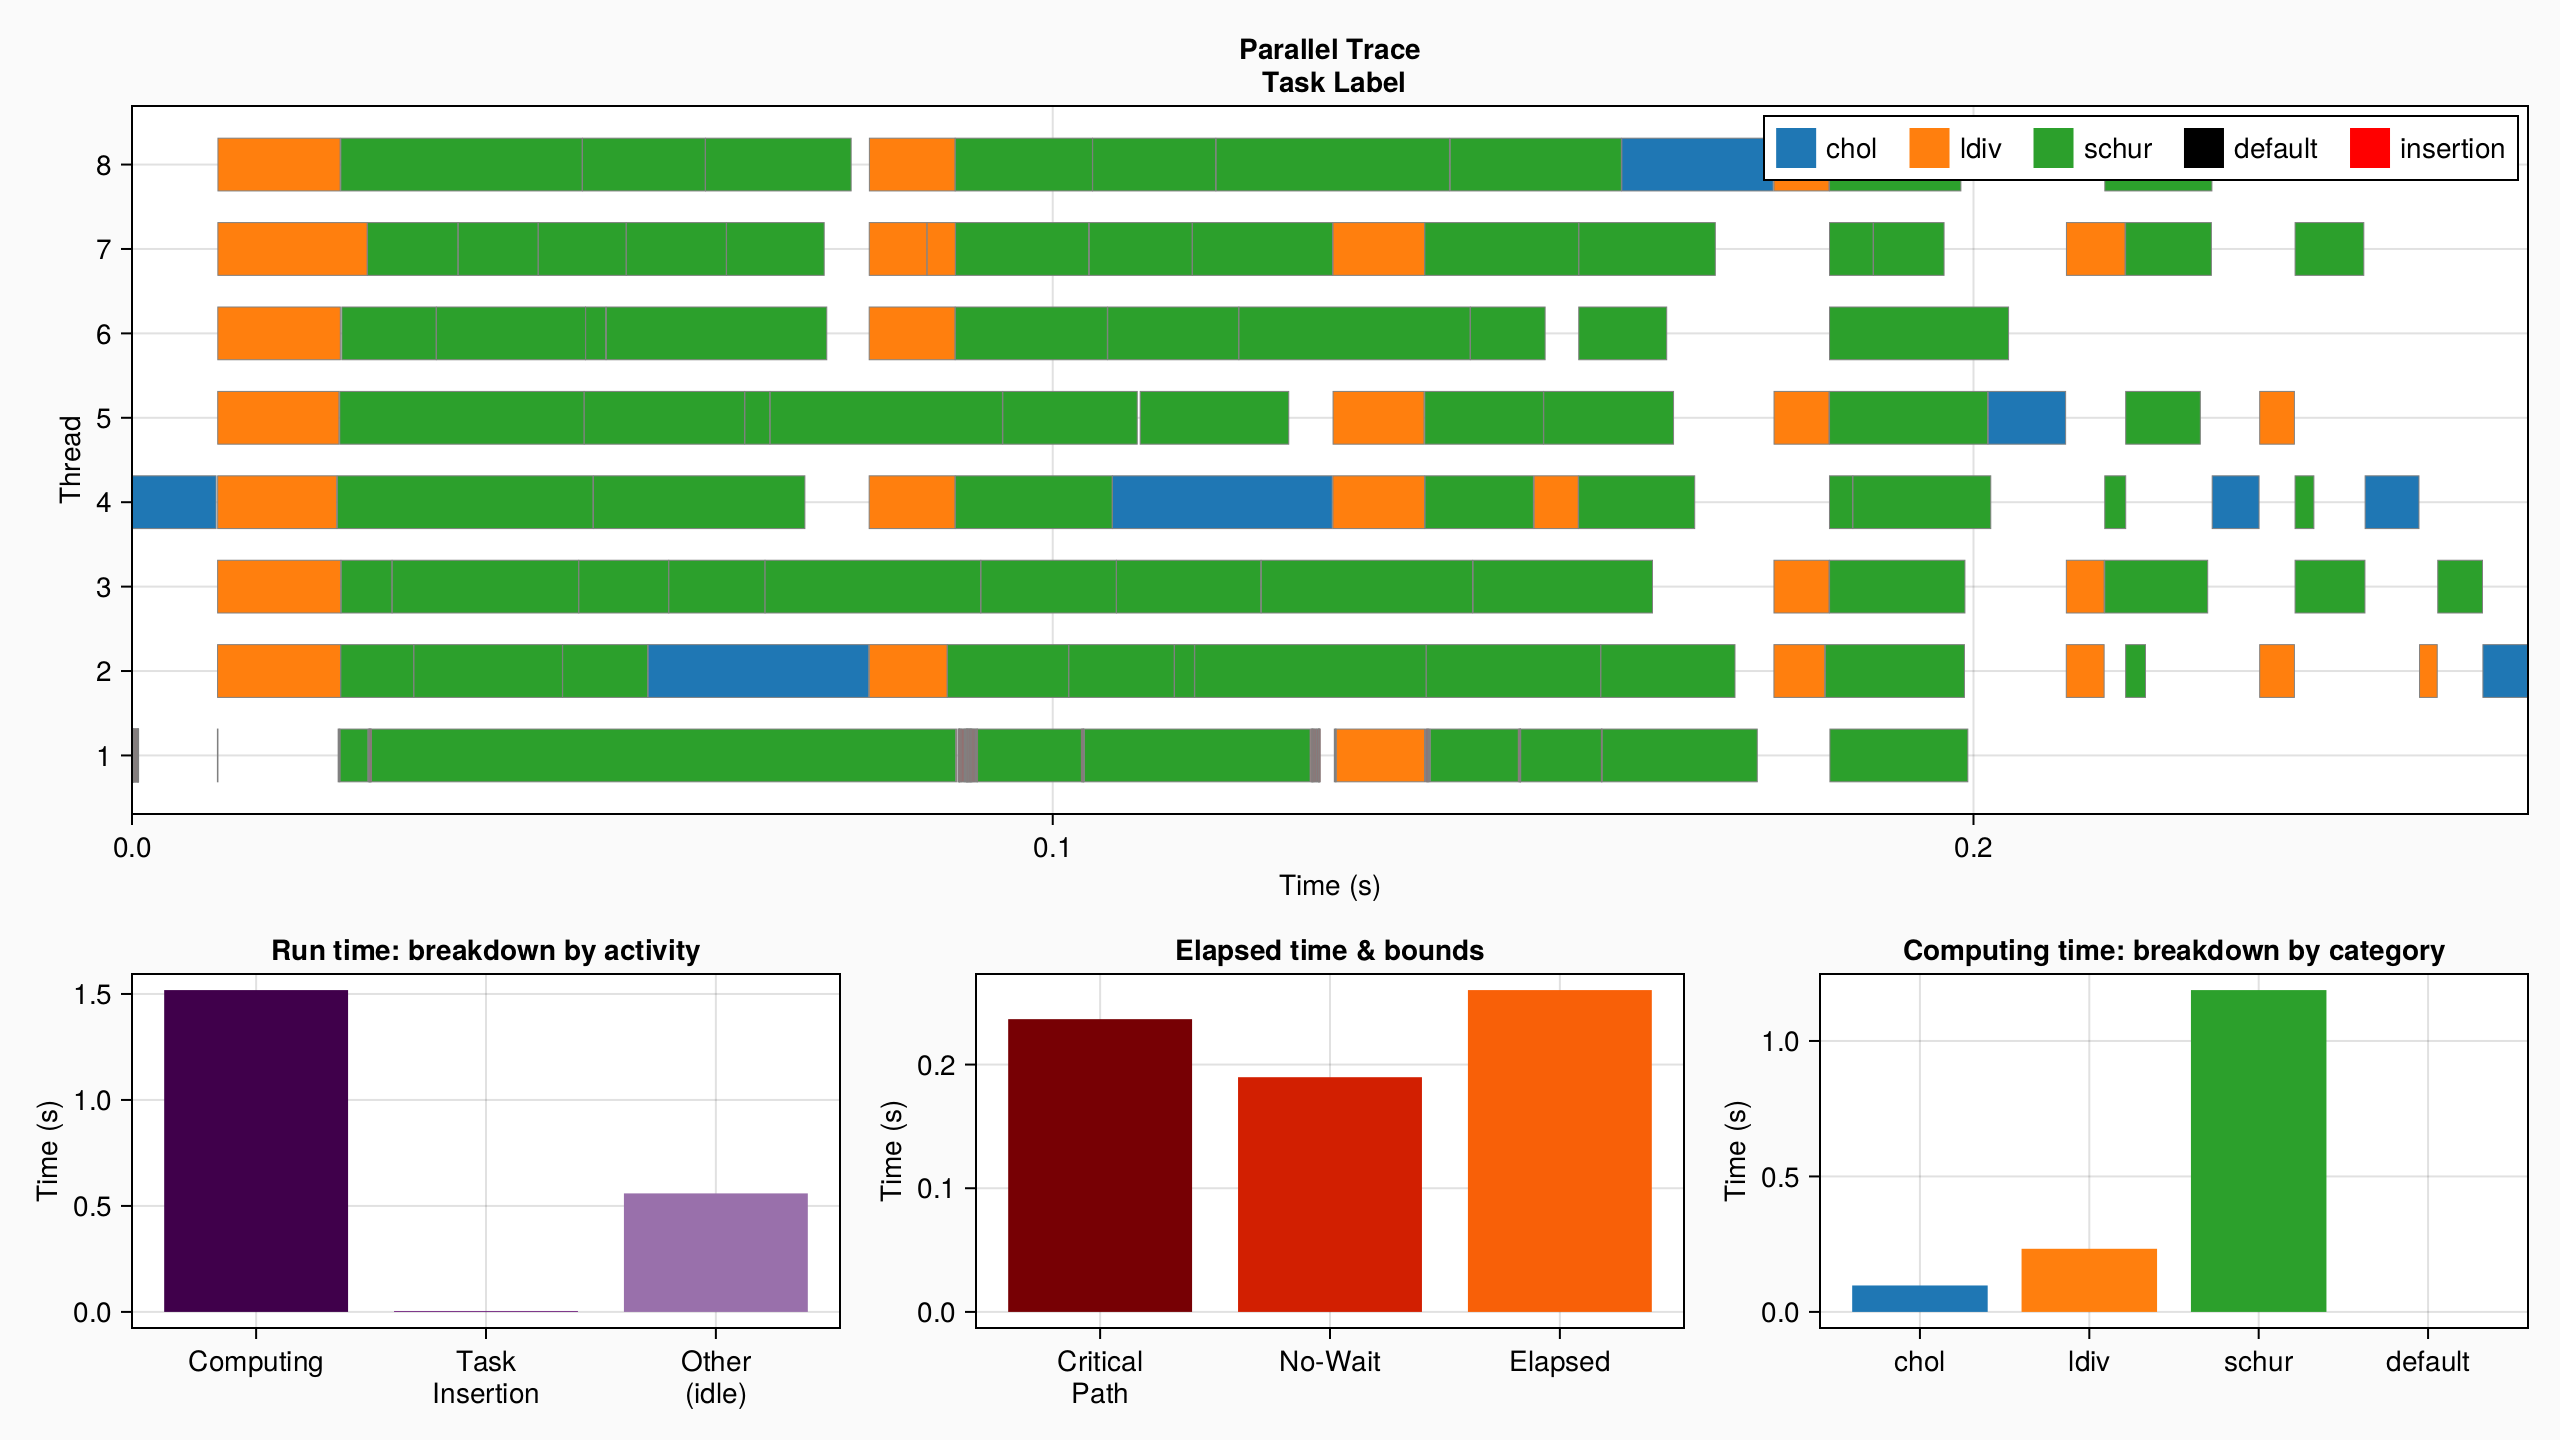

In [10]:
using CairoMakie # or GLMakie in order to have more interactivity
trace = plot(log_info; categories=["chol", "ldiv", "schur"])

The overhead incurred by `DataFlowTasks` seems relatively small here: the time
taken inserting tasks is barely measurable, and the scheduling did not lead to
threads waiting idly for too long. This is confirmed by the bottom middle
plot, showing a measured wall clock time not too much longer than the lower
bound obtained when suppressing idle time.

The "Computing time: breakdown by category" plot seems to indicate that the
matrix multiplications performed in the "Schur" tasks account for the majority
of the computing time. This routine is probably already quite fast since it
simply calls our *BLAS* library for a *matrix-matrix* product; it would be
interesting, however, to see how
[`LoopVectorization.jl`](https://github.com/JuliaSIMD/LoopVectorization.jl)
fares here!

# Performances

To benchmark the performance, we will compare our implementation to the one
provided by our system's BLAS library. We will use
[OpenBlas](https://www.openblas.net) here because it is the default BLAS
library shipped with *Julia*, but if you have access to Intel's MKL, you
should probably give it a try! Here is the benchmark:

In [11]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1

# n × n symmetric positive definite matrix
function spd_matrix(n)
    A = rand(n, n)
    A = (A + adjoint(A))/2
    return A + n*I
end

function bench_blas(n)
    nt = Threads.nthreads()
    BLAS.set_num_threads(nt)
    return @belapsed cholesky!(A) setup=(A=spd_matrix($n)) evals=1
end

function bench_tiled(n;tilesize=256)
    BLAS.set_num_threads(1)
    return @belapsed cholesky_tiled!(A, $tilesize) setup=(A=spd_matrix($n)) evals=1
end

function bench_dft(n;tilesize=256)
    BLAS.set_num_threads(1)
    return @belapsed cholesky_dft!(A, $tilesize) setup=(A=spd_matrix($n)) evals=1
end

bench_dft (generic function with 1 method)

Let us compare the performances of the default *BLAS*  library and ours for
various matrix sizes, and plot the results:

In [12]:
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.so

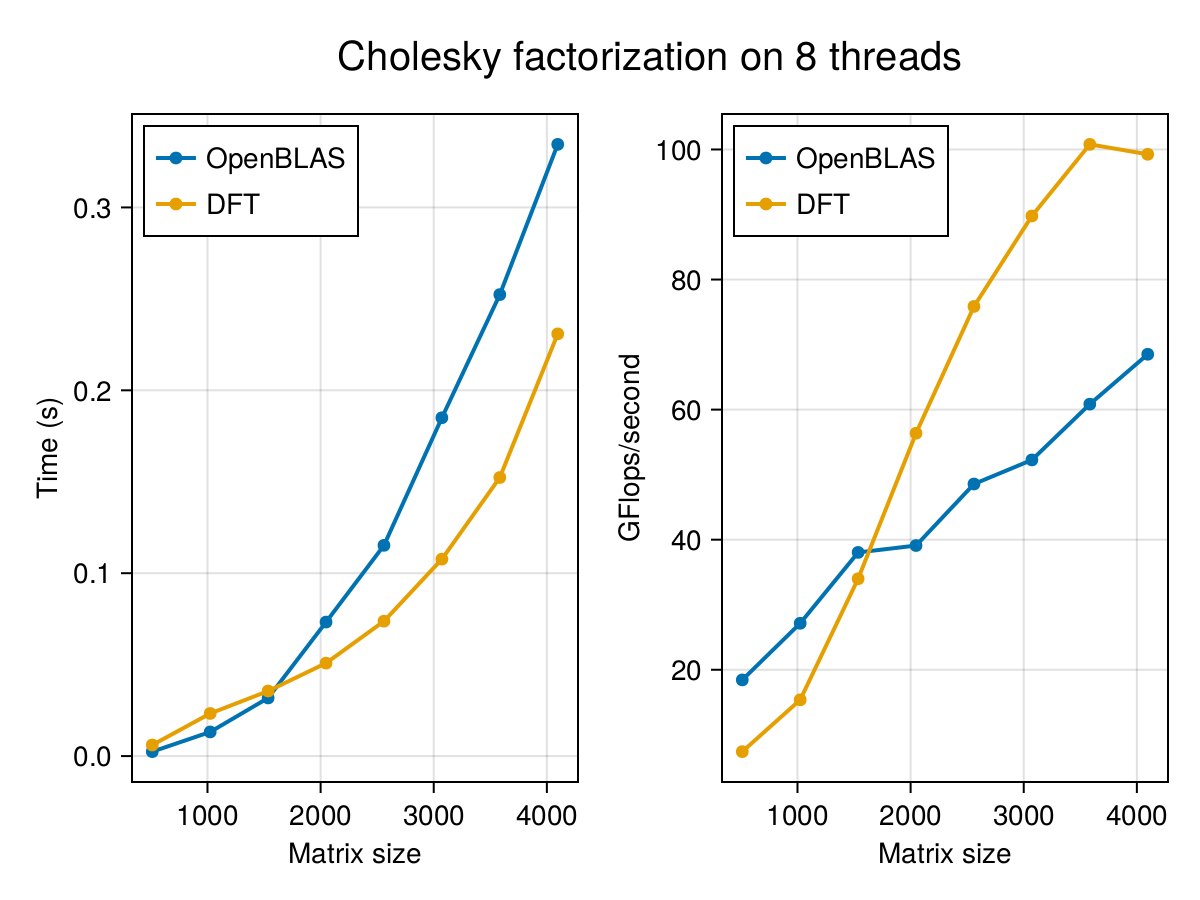

In [13]:
nsizes = 512 .* (1:1:8)
tblas  = map(bench_blas, nsizes)
tdft   = map(bench_dft, nsizes)
Gflops =  map(n->(1/3*n^3 + 1/2*n^2)/10^9, nsizes)

fig = Figure()
ax  = Axis(fig[1,1], xlabel="Matrix size", ylabel="Time (s)")
scatterlines!(ax, nsizes, tblas, label= "OpenBLAS", linewidth=2)
scatterlines!(ax, nsizes, tdft, label="DFT", linewidth=2)
axislegend(position=:lt)
ax  = Axis(fig[1,2], xlabel="Matrix size", ylabel="GFlops/second")
scatterlines!(ax, nsizes, Gflops ./ tblas, label= "OpenBLAS", linewidth=2)
scatterlines!(ax, nsizes, Gflops ./ tdft, label="DFT", linewidth=2)
axislegend(position=:lt)
Label(fig[0,:],  "Cholesky factorization on $(Threads.nthreads()) threads", fontsize=20)
fig

We see that, despite the simplicity of the implementation, the parallel
version performs *in par* with the default *BLAS* library for the matrix sizes
considered! For very large matrices, further optmizations are probably
necessary to take into account the memory hierarchy of the machine. Finally,
here is the observed speedup compared to a sequential tiled implementation and
a matrix of size $n=4096$:

In [14]:
(;
 threads = Threads.nthreads(),
 speedup = bench_tiled(4096) / bench_dft(4096),
)

(threads = 8, speedup = 5.485771700677603)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*